In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
#conda install -c conda-forge ipywidgets
#conda install nodejs
#jupyter labextension install @jupyter-widgets/jupyterlab-manager

import os, sys, shutil, glob, re, subprocess, fileinput
import pandas as pd
import numpy as np
from math import floor
from ipywidgets import widgets
from ipywidgets import interact
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('ggplot')

%matplotlib notebook

# Set atoms for colvars

In [3]:

pdbFile = "./setup/decarboxylase.0.pdb"
psfFile = "./setup/decarboxylase.0.psf"

#dcdFile = "./SMD_Data/min_smd.dcd"
#xstFile = "./SMD_Data/min_smd.xst"
dcdFile = "./SMD_Data/smd.dcd"
xstFile = "./SMD_Data/smd.xst"

stringNumIter = 10
stringNumWalkers = 5
atomDistList = []

### Decarboxylase

#  WARNING:  0-based index for VMD!!!
#  WARNING:  1-based index for colvars!!!

# This list should be built with VMD's 0-based index
atomDistList.append( (3311,3312,"OMP C6 <-> OMP C7") )
atomDistList.append( (3311,1020,"OMP C6 <-> Lys61 HZ1") )
atomDistList.append( (3314,980,"OMP OA <-> Asp59 OD2") )
atomDistList.append( (3313,979,"OMP OB <-> Asp59 OD1") )

atomDistList

[(3311, 3312, 'OMP C6 <-> OMP C7'),
 (3311, 1020, 'OMP C6 <-> Lys61 HZ1'),
 (3314, 980, 'OMP OA <-> Asp59 OD2'),
 (3313, 979, 'OMP OB <-> Asp59 OD1')]

# Set paths for tools used along the tutorial

In [4]:

qmBinPath = "/Scr/rcbernardi-new/Software/mopac/MOPAC2016.exe"

if sys.platform == 'linux':
    catdcdPath = "catdcd"
    vmdPath = "vmd"
elif sys.platform == 'darwin':
    catdcdPath = "/Applications/VMD\ 1.9.4.app/Contents/vmd/plugins/MACOSXX86/bin/catdcd5.2/catdcd"
    vmdPath = "/Applications/VMD\ 1.9.4.app/Contents/Resources/VMD.app/Contents/MacOS/vmd"

# Create TCL that loads DCD and calculates colvar values over trajectory to save in a CSV.

In [5]:
tclOut = open("./tmp/calc_distances.tcl","w")

# Creates strings that will be written to a TCL file, and executed by VMD
fileStrings = []

# Loads PSF and DCD files
fileStrings.append("set molID [ mol new " + psfFile + "] \n")
#fileStrings.append("mol addfile " + pdbFile + "\n")
fileStrings.append("mol addfile " + dcdFile + " waitfor all molid $molID \n")

# Gets number of frames and opens CSV output file.
fileStrings.append("""

set numFrames [molinfo $molID get numframes]

puts \"Number of frames: $numFrames\"

set fpCVDat [open "./tmp/cv_data.csv" w]

""")

# Sets the distance tracking for the chosen pairs of atoms, and create variables for plotting and analysis.
headerStr = ""
distStr = ""
keyNameDic = {}
measureStrings = []
for indx in range(len(atomDistList)):
    
    distSel = atomDistList[indx]
    measureStrings.append("\t# Distance " + str(indx) + ": " + str(distSel[2]) + "\n")
    measureStrings.append("\tset dist" + str(indx) + " [ measure bond {" + str(distSel[0]) + " " + \
                          str(distSel[1]) + "} molid $molID ] \n\n")
    
    if indx > 0:
        comma = ","
    else:
        comma = ""
    distStr += comma + "$dist" + str(indx)
    headerStr += comma + "dist" + str(indx)
    
    keyNameDic["dist"+str(indx)] = str(distSel[2])


# Writes header to CSV file
fileStrings.append("puts $fpCVDat \"" + headerStr + "\" \n")

# Initiates loop for ColVar tracking.
fileStrings.append("""

for {set frame 0} {$frame < $numFrames} {incr frame} { 

    animate goto $frame
    
""")

# Adds lines that calculate atom distances.
fileStrings += measureStrings

# Writes distance data to CSV file
fileStrings.append("\tputs $fpCVDat \"" + distStr + "\" \n")

# Ends loop and closes CSV file
fileStrings.append("""
}

close $fpCVDat 

""" )

tclOut.writelines(fileStrings)

tclOut.close()

# Run VMD with TCL script

In [6]:
%%bash -s "$vmdPath"

eval $1 -dispdev text -e ./tmp/calc_distances.tcl


Info) VMD for LINUXAMD64, version 1.9.4a14 (March 1, 2018)
Info) http://www.ks.uiuc.edu/Research/vmd/                         
Info) Email questions and bug reports to vmd@ks.uiuc.edu           
Info) Please include this reference in published work using VMD:   
Info)    Humphrey, W., Dalke, A. and Schulten, K., `VMD - Visual   
Info)    Molecular Dynamics', J. Molec. Graphics 1996, 14.1, 33-38.
Info) -------------------------------------------------------------
Info) Multithreading available, 8 CPUs detected.
Info)   CPU features: SSE2 
Info) Free system memory: 7097MB (29%)
Info) Creating CUDA device pool and initializing hardware...
Info) Detected 1 available CUDA accelerator:
Info) [0] GeForce GTX TITAN Black 15 SM_3.5 0.98 GHz, 5.9GB RAM, AE1, ZCP
Info) Detected 1 available TachyonL/OptiX ray tracing accelerator
Info)   Compiling 1 OptiX shaders on 1 target GPU...
Info) Dynamically loaded 2 plugins in directory:
Info) /Projects/vmd/pub/linux64/lib/vmd194a14/plugins/LINUXAMD64/molf

# Load CSV in Python for frame selection
### Explain Pandas
### Explain Melt/Cast

In [7]:
cvDat = pd.read_csv("./tmp/cv_data.csv")
numFrames = len(cvDat)
numColvars = len(cvDat.columns)

cvDatMelt = pd.melt(cvDat, var_name="colvar", value_name="Distance")

# Retreive data from selected frames

<IPython.core.display.Javascript object>


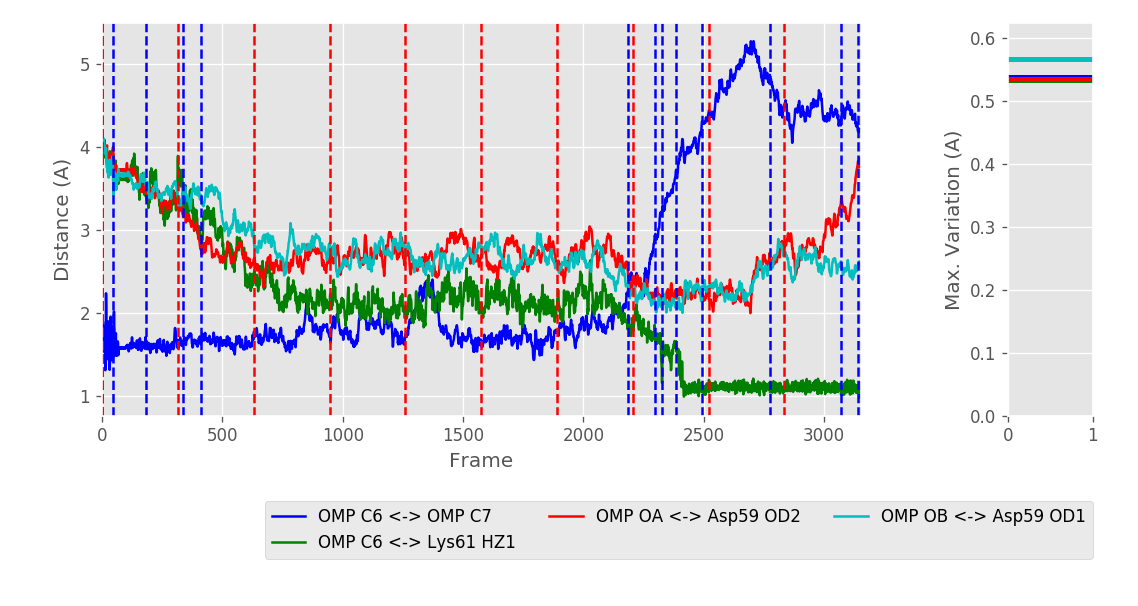

In [8]:
%matplotlib notebook

# Initializes number of frames between images as one tenth of total frames, rounding down, and 
# making sure we have at least 1 (one) frame between images
def getImagesES(defaultNumImgs=10):
    imgStride = max(floor(numFrames/defaultNumImgs),1)
    return [x*imgStride for x in range(defaultNumImgs)]
imagesES = getImagesES(10)
numImgs = len(imagesES)

# Initializes list of intermediate images
imagesInt = []

# Sets widgets to select number of images
imagesText = widgets.BoundedIntText(
    value=numImgs, step=1, min=3, max=numFrames, 
    description="Number of Images:",
    style={'description_width': 'initial'}
)
imagesSlider = widgets.IntSlider(
    value=numImgs, step=1, readout=False, min=3, max=numFrames
)
resetSelB = widgets.Button(
    value=False,
    description='Reset Selection',
    disabled=True,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Resets all selections and allows a new set of evenly spaced images to be created.',
    icon='eraser'
)

mylink = widgets.jslink((imagesText, 'value'), (imagesSlider, 'value'))

hboxImgs = widgets.HBox([imagesText,imagesSlider,resetSelB])

# Sets widgets to automatically create images in high variability regions.
activateInterTB = widgets.ToggleButton(
    value=False,
    description='Add Intermediates',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Adds intermediate images in regions of high variability. \
This will lock the number of evenly spaced images selected above.',
    icon='square' # "check-square" vs "square"
)
defaultMaxDelta = 0.3
maxDeltaFT = widgets.BoundedFloatText(
    value=defaultMaxDelta, min=0, 
    description="Maximum delta:",
    style={'description_width': 'initial'},
    disabled=True
)
addLastTB = widgets.ToggleButton(
    value=True,
    description='Add last frame',
    style={'description_width': 'initial'},
    disabled=True,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Add an image at the last step of the simulation.',
    icon='check-square' # "check-square" vs "square"
)
calcInterB = widgets.Button(
    value=False,
    description='calculate',
    disabled=True,
    button_style='warning', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='(Re)Calculate intermediate images. This may take some time.',
    icon='retweet'
)

hboxInter = widgets.HBox([activateInterTB, maxDeltaFT, addLastTB, calcInterB])

# Sets widgets to select number of images
totalImagesText = widgets.Text(
    value='0',
    description='Total Images:',
    disabled=False
)

hboxFT = widgets.HBox([totalImagesText])

def toggle_addLast(*args):
    if addLastTB.value:
        addLastTB.icon = "check-square"
    else:
        addLastTB.icon = "square"

addLastTB.observe(toggle_addLast,"value")

# Connects inputs
def toggle_intermediate(*args):
    # Activate user input
    
    # Change icon and Lock Image Selection.
    if activateInterTB.value:
        activateInterTB.icon = "check-square"
        maxDeltaFT.disabled = False
        addLastTB.disabled = False
        calcInterB.disabled = False
        
        imagesText.disabled = True
        imagesSlider.disabled = True
        resetSelB.disabled = False
    else:
        activateInterTB.icon = "square"
        maxDeltaFT.disabled = True
        addLastTB.disabled = True
        calcInterB.disabled = True
        
activateInterTB.observe(toggle_intermediate, "value")


# Displays both widgets
ui = widgets.VBox([hboxImgs, hboxInter, hboxFT])
display(ui)

# Build basic plot
xrange = np.arange(0, numFrames, 1)

fig = plt.figure()
gs = gridspec.GridSpec(2, 2, width_ratios=[9, 1], height_ratios=[7,1])
ax = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])
lax = plt.subplot(gs[1,:])

ax.set(xlabel='Frame', ylabel='Distance (A)')
ax1.set(xlabel='', ylabel='Max. Variation (A)')
ax1.set_ylim([0,1.5])

plt.show()

colors = ['b','g','r','c','m']
styles = ['-','-.','--',':']
styleTupls = []

def getStyleTupl(i):
    #if i > len(styleTupl):
    #    cIndx = i%len(colors)
    #    sIndx = int(i/len(colors))
    #    styleTupl.append((colors[cIndx],styles[sIndx]))
    cIndx = i%len(colors)
    sIndx = int(i/len(colors))
    return (colors[cIndx],styles[sIndx])

deltaLines = []
# Populate with selected colvar values
for key, grp in cvDatMelt.groupby(['colvar']):
    colStyl = getStyleTupl(len(styleTupls))
    styleTupls.append( colStyl )
    ax = grp.plot(ax=ax, kind='line', x=xrange, y='Distance', label=keyNameDic[key], 
                  color=colStyl[0], style=colStyl[1])
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.20),
    #      ncol=3, fancybox=True, shadow=True)
    
    # Initializes points used for CV deltas
    deltaLines.append(ax1.axhline(y=0, linewidth=3, 
                                  label=key, color=colStyl[0], linestyle=colStyl[1]) )
    
    plt.draw()

ax.set_xlim([-2,numFrames+2])

h,l = ax.get_legend_handles_labels()
lax.legend(h,l, borderaxespad=0, ncol=3)
lax.axis("off")

ax.legend().set_visible(False)
ax1.legend().set_visible(False)

linesList = []

def update_imagesES(*args):
    global imagesES, imagesInt
    imagesES = getImagesES(imagesText.value)
    update_plot()

imagesText.observe(update_imagesES, 'value')

def update_TotImgs(*args):
    global imagesES, imagesInt
    totalImagesText.value = str(len(imagesES) + len(imagesInt))

imagesText.observe(update_TotImgs, 'value')

# Determines the maximum variation in ColVar values between sequential images.
def find_max_delta():
    global imagesES, imagesInt
    
    maxDeltaCV = [0]*len(cvDat.columns)
    
    allImgs = imagesES + imagesInt
    allImgs.sort()
    
    for indx in range(1,len(allImgs)):
        frameFin = allImgs[indx]
        frameIni = allImgs[indx -1]
        for colIndx in range(len(cvDat.columns)):
            delta = abs( cvDat.iloc[frameFin,colIndx] - cvDat.iloc[frameIni,colIndx] )
            if maxDeltaCV[colIndx] < delta:
                maxDeltaCV[colIndx] = delta
    
    return(maxDeltaCV)

def toggle_reset(*args):
    global imagesES, imagesInt
    
    # Resets interface
    imagesText.disabled = False
    imagesSlider.disabled = False
    resetSelB.disabled = True
    
    activateInterTB.value = False
    toggle_intermediate()
    
    # Resets user input data
    maxDeltaFT.value = defaultMaxDelta
    imagesText.value = 10.0
    
    imagesES = getImagesES(imagesText.value)
    imagesInt = []
    
    # updates plot
    update_plot()
    update_TotImgs()
    
resetSelB.on_click(toggle_reset)

def update_plot():
    global imagesES, imagesInt
    # Initialize Images on the plot
    
    lineIndx = 0
    for frame in imagesES:
        if lineIndx < len(linesList):
            linesList[lineIndx].set_xdata(frame)
            linesList[lineIndx].set_color("r")
        else:
            linesList.append( ax.axvline(x=frame, color="r", linestyle="--") )
        lineIndx += 1
    
    for frame in imagesInt:
        if lineIndx < len(linesList):
            linesList[lineIndx].set_xdata(frame)
            linesList[lineIndx].set_color("b")
        else:
            linesList.append( ax.axvline(x=frame, color="b", linestyle="--") )
        lineIndx += 1
    
    while lineIndx < len(linesList):
        linesList[lineIndx].set_xdata(imagesES[0])
        linesList[lineIndx].set_color("r")
        lineIndx += 1
    
    maxDeltaCV = find_max_delta()
    
    index = 0
    for delta in maxDeltaCV:
        deltaLines[index].set_ydata(delta)
        index += 1
    
    ax1.set_ylim([0,max(maxDeltaCV)*1.1])
    
    fig.canvas.draw()

def calcIntermediates():
    
    global imagesES, imagesInt
    imagesInt = []
    
    # Gets current Maximum Delta
    maxD = float(maxDeltaFT.value)
    
    imagesTmp = imagesES.copy()
    lastFrame = []
    
    if addLastTB.value:
        if (imagesES[-1] != (len(cvDat)-1)):
            lastFrame.append(len(cvDat)-1)
            imagesTmp += lastFrame
    
    # Loops over all Equally Spaced "gaps"
    for indx in range(1,len(imagesTmp)):
        
        frameFin = imagesTmp[indx]
        frameIni = imagesTmp[indx -1]
        
        checkRegion = True
        while checkRegion:
            
            newImages = []
            
            for colIndx in range(len(cvDat.columns)):

                #print("Frames:",frameIni,frameFin)
                
                # If the difference in this colvar is less than the maximum,
                # skip to the next.
                tmpdelta = abs( cvDat.iloc[frameFin,colIndx] - cvDat.iloc[frameIni,colIndx] )
                if tmpdelta <= maxD:
                    continue
                
                # Ungly trick to get the first frame, between two images, with a ColVar
                # variation langer than maxD. 
                # R + data.table would do this much more "cleanly", but I'll stop complaining...
                baseVal = cvDat.iloc[frameIni,colIndx]
                queryStr = "abs(" + str(baseVal) + "-" + str(cvDat.columns[colIndx]) + ") > " + str(maxD)
                indxV = cvDat.iloc[frameIni:frameFin,:].query(queryStr)
                
                # In case there is at least one frame where this ColVar has a variation greater than maxD,
                # we store the frame.
                if len(indxV) > 0 :
                    newImages.append(indxV.index[0])
            
            if len(newImages):
                frameIni = min(newImages)
            
                # Add the new image to the list
                imagesInt.append(frameIni)
                
            else:
                checkRegion = False
            
    
    imagesInt += lastFrame
    
    return(imagesInt)

def toggle_calcInter(*args):
    global imagesES, imagesInt
    imagesES = getImagesES(imagesText.value)
    imagesInt = calcIntermediates()
    update_plot()
calcInterB.on_click(toggle_calcInter)
calcInterB.on_click(update_TotImgs)

update_plot()

update_TotImgs()

plt.tight_layout()
plt.show()

In [9]:
frames = imagesES + imagesInt

frames.sort()

numImgs = len(frames)

print("We selected",numImgs,"images:",frames)


We selected 23 images: [0, 46, 184, 315, 336, 410, 630, 945, 1260, 1575, 1890, 2186, 2205, 2297, 2326, 2384, 2491, 2520, 2774, 2835, 3069, 3141, 3152]


In [10]:
def calcIntermediates():
    
    global imagesES, imagesInt
    imagesInt = []
    
    # Gets current Maximum Delta
    maxD = float(maxDeltaFT.value)
    
    imagesTmp = imagesES.copy()
    lastFrame = []
    
    if addLastTB.value:
        if (imagesES[-1] != (len(cvDat)-1)):
            lastFrame.append(len(cvDat)-1)
            imagesTmp += lastFrame
    
    # Loops over all Equally Spaced "gaps"
    for indx in range(1,len(imagesTmp)):
        
        frameFin = imagesTmp[indx]
        frameIni = imagesTmp[indx -1]
        
        print("-------> ",indx,frameIni,frameFin)
        
        checkRegion = True
        while checkRegion:
            
            newImages = []
            
            for colIndx in range(len(cvDat.columns)):

                print("Column:", colIndx,"Frames:",frameIni,frameFin)
                
                # If the difference in this colvar is less than the maximum,
                # skip to the next.
                tmpdelta = abs( cvDat.iloc[frameFin,colIndx] - cvDat.iloc[frameIni,colIndx] )
                print("delta:", round(tmpdelta,3))
                if tmpdelta <= maxD:
                    continue
                
                # Ungly trick to get the first frame, between two images, with a ColVar
                # variation langer than maxD. 
                # R + data.table would do this much more "cleanly", but I'll stop complaining...
                baseVal = cvDat.iloc[frameIni,colIndx]
                queryStr = "abs(" + str(baseVal) + "-" + str(cvDat.columns[colIndx]) + ") > " + str(maxD)
                indxV = cvDat.iloc[frameIni:frameFin,:].query(queryStr)
                
                # In case there is at least one frame where this ColVar has a variation greater than maxD,
                # we store the frame.
                if len(indxV) > 0 :
                    newImages.append(indxV.index[0])
                    print("Found:",indxV.index[0])
            
            if len(newImages):
                frameIni = min(newImages)
                print("New intermediate:", frameIni)
                # Add the new image to the list
                imagesInt.append(frameIni)
                
            else:
                checkRegion = False
            
    
    imagesInt += lastFrame
    
    return(imagesInt)
calcIntermediates()

------->  1 0 315
Column: 0 Frames: 0 315
delta: 0.078
Column: 1 Frames: 0 315
delta: 0.009
Column: 2 Frames: 0 315
delta: 0.82
Found: 113
Column: 3 Frames: 0 315
delta: 0.629
Found: 46
New intermediate: 46
Column: 0 Frames: 46 315
delta: 0.199
Column: 1 Frames: 46 315
delta: 0.068
Column: 2 Frames: 46 315
delta: 0.62
Found: 184
Column: 3 Frames: 46 315
delta: 0.062
New intermediate: 184
Column: 0 Frames: 184 315
delta: 0.002
Column: 1 Frames: 184 315
delta: 0.401
Column: 2 Frames: 184 315
delta: 0.085
Column: 3 Frames: 184 315
delta: 0.136
------->  2 315 630
Column: 0 Frames: 315 630
delta: 0.089
Column: 1 Frames: 315 630
delta: 1.476
Found: 336
Column: 2 Frames: 315 630
delta: 0.659
Found: 407
Column: 3 Frames: 315 630
delta: 0.503
New intermediate: 336
Column: 0 Frames: 336 630
delta: 0.104
Column: 1 Frames: 336 630
delta: 0.942
Found: 410
Column: 2 Frames: 336 630
delta: 0.524
Found: 458
Column: 3 Frames: 336 630
delta: 0.542
Found: 525
New intermediate: 410
Column: 0 Frames: 410 

[46, 184, 336, 410, 2186, 2297, 2326, 2384, 2491, 2774, 3069, 3141, 3152]

# Creates COOR and XSC files to initiate String calculation

In [ ]:
        
setupPath = "String_eABF/setup/"
outputPath = "String_eABF/output/"

# Erases setup files if they exist. We start from scratch to avoid future errors.
if os.path.exists("String_eABF"):
    shutil.rmtree("String_eABF")
os.makedirs(setupPath)
os.makedirs(outputPath)

# Creates output directories for each image
for i in range(numImgs*stringNumWalkers):
    os.makedirs(outputPath + "/" + str(i))

print("Total selected frames:",len(frames))

stringFileList = []
stringIndex = 0
for frame in frames:
    
    # Creates a list of DCD files that will be used to write configuration files for the String.
    stringFileList.append("image_"+str(stringIndex)+".coor")
    
    # Writes selected frames to DCD files for String input
    print("Writing frame " + str(frame) + " to file " + stringFileList[-1])
    command = catdcdPath + " -o " + setupPath + stringFileList[-1] + " -otype namdbin -stype psf -s " + psfFile + \
        " -first " + str(frame+1) + " -last " + str(frame+1) + " -dcd " + dcdFile
    process = subprocess.Popen(command, shell=True)
    process.wait()

    # Exact frames from the XST file for String input
    sedFile = setupPath + "image_" + str(stringIndex) + ".xsc"
    tmpFile = open(sedFile,"w")
    tmpFile.write("""# NAMD extended system trajectory file
#$LABELS step a_x a_y a_z b_x b_y b_z c_x c_y c_z o_x o_y o_z
""")
    tmpFile.close()
    sedLine = "sed -n " + str(frame + 1) + "p " + xstFile + " >> " + sedFile 
    process = subprocess.Popen(sedLine, shell=True)
    process.wait()
    
    stringIndex += 1


# Creates Configuration files to initiate String calculation

### We create configuration files for both String and eABF because we already have all the necessary data and parameters for both, but the eABF calculation will still need structural data that we will gather from the results of the String optimization.

In [ ]:

##### Writes all configuration files for the String Method optimization.

# First we create the common block of text for defining Colective Variables, and use python's "format" capability
# to insert data for each ColVar, in each Image.
# OBS: In Python's "format" module, every keyword enclosed in curly brackets will be substituted by a value 
#  provided in a dictionary. If the final string needs actual curly brackets, they can be excaped by using 
#  two consecutive brackets.

colvarBlock = """
# {CVlabel}
colvar {{
    name swarms_atmDist{CVcolIndx}
    distance {{
        group1 {{
            atomNumbers {atmIndx1}
        }}
        group2 {{
            atomNumbers {atmIndx2}
        }}
    }}
}}

harmonic {{
    name bias_swarms_atmDist{CVcolIndx}
    colvars swarms_atmDist{CVcolIndx}
    centers {CVcenter}
    forceConstant 0.0
}}

"""

# Now we write each file (one per image), containing their particular initial values for the ColVars.
for imgIndx in range(len(frames)):
    
    # We create one file per image in the string.
    stringFile = open(setupPath + "colvars_" + str(imgIndx) + ".conf",'w')
    
    # Common colvar communication freqeuncy
    stringFile.write("\ncolvarsTrajFrequency 20\n\n")
    
    for colIndx in range(len(cvDat.columns)):
        colName = cvDat.columns[colIndx]
        
        #print("Frame " + str(imgIndx) + "; Dim " + colName + "; indxPair: " + str(atomDistList[colIndx][0]) \
        #      + " <-> " + str(atomDistList[colIndx][1]) + "; label: " + atomDistList[colIndx][2])
        
        # Now we aggregate the information for each colvar and each image.
        currInfo = {}
        currInfo['CVlabel'] = atomDistList[colIndx][2]
        currInfo['CVcolIndx'] = str(colIndx)
        # Convert VMD 0-base index to ColVar 1-base index.  
        currInfo['atmIndx1'] = atomDistList[colIndx][0] + 1
        currInfo['atmIndx2'] = atomDistList[colIndx][1] + 1
        currInfo['CVcenter'] = cvDat.iloc[frames[imgIndx],colIndx]
        
        # Finally, we substitute the values in the common string block and write it to the file.
        stringFile.write( colvarBlock.format(**currInfo) )
    
    
    stringFile.close()
########



In [ ]:

##### Writes the configuration file for the eABF Free Energy calculation.

# Path Collective Variables use the RMSD of relevant atoms to describe the reaction coordinate. For that, we need 
# the atom numbers of all atoms involved in colvars we set at the begining of the notebook.
# We can use python's flexibility to create a unique set of atom indices in one line.
# Warning: Computational tricks ahead! Using "list comprehension", we can create a list by calling each colvar
#    (or cv) in atomDistList, select only the frist two items (the 0-based atom indices) and create
#    a set for with them shifted to 1-based index. List comprehensions, automatically combine all pairs in a list 
#    (by doing this operation within brackets), and the resulting list of sets is unpacked by placing an '*' in 
#    fornt of it. The unpacked list of sets is used by the 'set.union' operation to create a union of all sets. 

atmsUnion = set.union(*[ set([cv[0]+1,cv[1]+1]) for cv in atomDistList ])

# An equivalent operation that would be easier to read can be found below, but we can take the oportunity to 
# get used to pyhton's toolset, writing 1 line of code instead of 4.
## atmsUnion = set()
## for cv in atomDistList:
##     for atm in [cv[0]+1,cv[1]+1]:
##         atmsUnion.add(atm)


# Sets common text block that will be used to set all points along the optimized string. 
# This defines the path that eABF will use to calculate the free energy.
# The atomNumbers are common to all points that define the path, so we add them to the common text block now.
allAtmsStr = ' '.join([str(atom) for atom in atmsUnion])
pathNodeStr = """
rmsd {{
 atoms {{
   atomNumbers {{ """ + allAtmsStr + """ }}
 }}
 refpositionsfile "${{imageRoot}}/string_{imgIndx}.pdb"
}}
"""

# Only one configuration file is needed for eABF.
pathCVFile = open(setupPath + "pathCV.conf",'w')

# We use the final images form a string optimization. Files have to be converted from coor to pdb.
pathCVFile.write("\nset imageRoot " + outputPath + "\n\n")

# Common colvar communication freqeuncy
pathCVFile.write("colvarsTrajFrequency 20\n\n")

# Now we set the two collective variables needed for eABF, the path collective variables.

# Colvar 's' defines the position of the simulations along the path
begCVs = """
colvar {
   name                  s

   width                 0.05
   lowerboundary         0.0
   upperboundary         1.0
   lowerwallconstant     10.0
   upperwallconstant     10.0

   scriptedFunction      pathCVs
   extendedLagrangian    on
   extendedFluctuation   0.01

"""
pathCVFile.write(begCVs)

# Writes all the definitions of points along the path.
for imgIndx in range(len(frames)):
    pathCVFile.write( pathNodeStr.format(**{'imgIndx': imgIndx}) )

# Closes the first colvar block
pathCVFile.write("}\n\n")

# Colvar 'z' defines the distance of the simulations 'perpendicular' the path
begCVz = """
colvar {
   name                  z

   width                 0.05
   lowerboundary        -0.5
   upperboundary         1.5

   scriptedFunction      pathCVz
   extendedLagrangian    on
   extendedFluctuation   0.01
"""
pathCVFile.write(begCVz)

# Writes all the definitions of points along the path.
for imgIndx in range(len(frames)):
    pathCVFile.write( pathNodeStr.format(**{'imgIndx': imgIndx}) )

# Closes the first colvar block
pathCVFile.write("}\n\n")

# We sill configure the eABF sampling to run only along the 's' variable. This will not give us
# the best possible estimate, but will be computationally cheaper since we need only sample one dimension.
# The eABF algorithm will apply forces on the virtual particle in a region only after acquiring 100 samples
# in that region. We are using multiple walkers initialized along the string to speed up the sampling process.
# The 'z' colective variable is only used to keep the eABF virtual particle from wandering away from the main 
# path.
configPathCV = """
abf {
    #colvars s z
    colvars s
    fullSamples 100

    # Multiple-replica ABF
    #shared yes
    #sharedFreq 20
    
    # CZAR is the default
    #CZARestimator yes
    #writeCZARwindowFile yes
    
    #historyFreq 100
}

harmonic {
   colvars               z
   centers               0.0
   forceConstant         0.5
}

"""
pathCVFile.write(configPathCV)

pathCVFile.close()

# Populate the String/eABF work directory with the necessary files.

### We now copy essential files from the decarboxylase system (such as PDB, PSF, topology) and configuration files from the 'templates' directory.
### Some of files need specific data that is only knwon after we setup our system, decide on parameters, chose images, etc.

In [ ]:

# Get structure data and NAMD parameters
shutil.copy(pdbFile, "./String_eABF/")
shutil.copy(psfFile, "./String_eABF/")

shutil.copytree('./setup/toppar', './String_eABF/toppar')

# Get TCL code and parameters for String and eABF calculation
for filename in glob.glob('./templates/*'):
    shutil.copy(filename, "./String_eABF/")

# Create directory in RAM for faster QM calculation and I/O.
# This path is used in the "namd.conf" file.

if sys.platform == 'linux':
    os.makedirs("/dev/shm/NAMD_SM_qmmm", exist_ok=True)

with fileinput.FileInput("./String_eABF/namd.conf", inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace("QMBINPATH", qmBinPath), end='')

with fileinput.FileInput("./String_eABF/string_param.conf", inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace("STRINGITERATIONS", str(stringNumIter)), end='')

with fileinput.FileInput("./String_eABF/string_param.conf", inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace("NUMWALKERS", str(stringNumWalkers)), end='')

## To visualize the file in the notebook, use the magic:
### %load "file-name"
## To save modifications made to file, add the following magic to the top of the cell (DO NOT use quotes around the file name!):
### %%writefile file-name

#
# Run the calculation!
#


### For fully parallel calculations in clusters (using multiple nodes), where all walkers from all swarms of all images walk at the same time, use the file "string_parallel.tcl".
### For single-node calculations, where wlakers of a same image walk sequentially, but walkers of different images walk simultaneously, use "string_sequential.conf". Warning: The node needs to have at least as many processor cores as there are images in the string.

### An example of a command that can be ran in the terminal window would be:

### mpirun -n 8 /Projects/melomcr/NAMD_Gerrit/namd/Linux-x86_64-g++.mpi/namd2 +replicas 8 string_parallel.tcl +stdout output/%1d/job00.%1d.log

## We backup the results just in case...

In [ ]:
resultsStringDirBase = "Results_String"

backupList = [dir for dir in glob.glob(resultsStringDirBase + "_*")]

newBackDir = resultsStringDirBase + "_" + str(len(backupList)+1)
print("Creating backup in",newBackDir,"... this may take a minute.")
shutil.copytree(outputPath, newBackDir)


# Read the results

In [ ]:
parallelExec = False
sequentialExec = True

if parallelExec:
    numOutFolders = numImgs*stringNumWalkers
elif sequentialExec:
    numOutFolders = numImgs

print("Examining output in",numOutFolders,"folders...")

In [ ]:

# We are looking for the following pattern inside the log file:
# Updating bias_swarms_atmDist1
# colvars:   # centers = { 4.14177 }
    
# First, we compile a Regular Expression to look for the correct format.
# Regular expression are a powerful tool to match patterns in text files that have complex formats.
regexVal = re.compile("^colvars:   # centers = { ([0-9\.]*) }$")
regexName = re.compile("^Updating bias_swarms_atmDist([0-9]*)$")

# Create a dataframe 
cvString = pd.DataFrame(columns=[ "dist"+str(i) for i in range(numColvars) ] + ["Image","Iter"])

# Initialize with colvar values taken from SMD simulation, that initiated the String optimization.
for i in range(numImgs):
    cvString.loc[i] = list(cvDat.iloc[frames[i],:]) + [i, 0]

# Loop over all images
for image in range(numImgs):
    
    if parallelExec:
        foldIndx = indx*stringNumWalkers
    else:
        foldIndx = indx
        
    folderStr = outputPath + str(foldIndx)
    for logFN in glob.iglob(folderStr + "/job*.log"):
        logFiles.append(logFN)
    
    ## Assuming there is only one log file per image, for now.
    fileName = logFiles[0]
    
    # Set temporary variables
    colvarName = ""
    numIterations = 1
    tmpDF = pd.DataFrame()
    
    with open(fileName,'r') as fileHandle:
        print("Processing file",fileName)
        
        for line in fileHandle:
            matchVal = regexVal.match(line.strip())
            matchName = regexName.match(line.strip())
            
            # First we check if the line provides a name for a colvar (the value will follow in the next line)
            if matchName:
                colvarName = line.strip().split(" ")[1]
                cvIndx = matchName.group(1)
            
            # We only consider matching value strings after we match at least one name string.
            if matchVal and colvarName:
                colvarValue = matchVal.group(1)
                
                tmpDF.loc[0,"dist" + str(cvIndx)] = colvarValue
                
            # After accumulating values for all colvars, append to data frame.
            if len(tmpDF.columns) == numColvars:
                tmpDF.loc[0,"Image"] = image
                tmpDF.loc[0,"Iter"] = numIterations
                
                #print("Appending", tmpDF)
                
                cvString = cvString.append(tmpDF)
                
                numIterations += 1
                # Resets temporary data frame
                tmpDF = pd.DataFrame()
    

In [ ]:
cvString